In [1]:
'''Benchmark #1'''

'''
- create a genetic algorithm for solid color canvases
- paintings will have the canvas color as an attribute
- paintings will reproduce by creating a child with a mean color
- random color generation will be implemented

- a population of randomly colored canvases will converge to a 
  reference image of a reference color
  
- side project idea: get this benchmark working and it will 
  serve as a handy 'color guesser (approximator)'
'''

import math
import random
import imgcompare
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [27]:
class Canvas:
    '''
    - handles only the background color of the painting
    '''
    def __init__(self):
        self.color = self.define_color()
    
    def __str__(self) -> str:
        return "{}".format(self.color)
    
    def define_color(self) -> list:
        R = random.randint(0, 255)
        G = random.randint(0, 255)
        B = random.randint(0, 255)
        return [R, G, B]


if __name__ == "__main__":
    canvases = [Canvas() for _ in range(0, 10)]
    for canvas in canvases: print("Color: {}".format(canvas))

Color: [31, 43, 170]
Color: [122, 190, 159]
Color: [62, 24, 244]
Color: [25, 106, 105]
Color: [239, 166, 169]
Color: [254, 251, 33]
Color: [48, 36, 44]
Color: [104, 98, 40]
Color: [80, 11, 122]
Color: [222, 101, 213]


In [29]:
class Painting:
    '''
    '''
    def __init__(self, width: int, height: int) -> None:
        self.width = width
        self.height = height
        self.genotype = Canvas()
        self.create_painting()
        self.fitness = 0
    
    def create_painting(self) -> None:
        self.phenotype = Image.new(mode = 'RGB',
                                   size = (self.width, self.height),
                                   color = tuple(self.genotype.color))
    
    def show_painting(self) -> None:
        self.phenotype.show()
    
    def save_painting(self, painting_id: int) -> None:
        '''
        - saves the populated image as a png file
        '''
        self.phenotype.save('../lib/benchmark1_test/test_painting{}.png'.format(str(painting_id)))
    
    def crossover(self, parent_genotype: object, mutation_rate: float) -> object:
        child = Painting(self.width, self.height)
        child.genotype.color[0] = int(0.5 * (self.genotype.color[0] + parent_genotype.color[0]))
        child.genotype.color[1] = int(0.5 * (self.genotype.color[1] + parent_genotype.color[1]))
        child.genotype.color[2] = int(0.5 * (self.genotype.color[2] + parent_genotype.color[2]))
        child.genotype.color[3] = int(0.5 * (self.genotype.color[3] + parent_genotype.color[3]))
        child.mutate(mutation_rate)
        return child
    
    def mutate(self, mutation_rate: float) -> None:
        for index in range(0, len(self.genotype.color)):
            if random.randint(1, int(1 / mutation_rate)) == 1:
                self.genotype.color[index] = self.genotype.color[index] + random.randint(-30, 30)


if __name__ == "__main__":
    painting = Painting(width = 400, height = 400)
    painting.show_painting()
    print('Color: {}'.format(painting.genotype))
    print('{}'.format(painting.__init__.__annotations__))

Color: [186, 22, 156]
{'width': <class 'int'>, 'height': <class 'int'>, 'return': None}


In [4]:
class Figure:
    '''
    '''
    def __init__(self, path: str) -> None:
        self.path = path
        self.image = Image.open(self.path)
        self.image = self.convert_image()
        self.width, self.height = self.image.size
        self.data = self.get_color_data(self.image)

    def calculate_fitness(self, input_painting: object) -> float:
        '''
        - for each pixel, determine the mean error of the color map
        '''
        input_painting = input_painting.phenotype.convert('RGB')
        diff1_percent = imgcompare.image_diff_percent(self.image, input_painting)
        return 100 - diff1_percent

    def convert_image(self) -> object:
        return self.image.convert('RGB')
    
    def get_color_data(self, image: object) -> list:
        return np.array(Image.Image.getdata(image))
        

if __name__ == "__main__":
    target = Figure('../lib/test_target1.png')
    print('{}'.format(target.data.shape))
    print('{}'.format(target.data[:30]))
    print('{}'.format(target.calculate_fitness(Painting(target.width, target.height))))

(45000, 3)
[[ 4  4 17]
 [ 3  4 16]
 [ 3  4 15]
 [ 3  4 14]
 [ 3  4 14]
 [ 1  4 14]
 [ 2  4 14]
 [ 3  4 14]
 [ 3  4 15]
 [ 3  4 16]
 [ 4  4 17]
 [ 4  4 18]
 [ 5  5 20]
 [ 5  5 22]
 [ 7  5 24]
 [ 8  5 26]
 [ 9  5 29]
 [11  5 31]
 [12  5 33]
 [12  6 35]
 [13  6 37]
 [15  6 39]
 [16  6 42]
 [16  6 43]
 [17  6 45]
 [18  7 47]
 [18  7 49]
 [19  7 51]
 [20  7 53]
 [20  7 54]]
47.34723311546841


In [18]:
class Population:
    '''
    '''
    def __init__(self, max_population: int, mutation_rate: float, target_path: str, size: int) -> None:
        self.max_population = max_population
        self.mutation_rate = mutation_rate
        self.target_path = target_path
        self.size = size
        self.target = Figure(self.target_path)
        self.population = [Painting(width = self.target.width,
                                    height = self.target.height) for _ in range(0, self.max_population)]
        self.children = []
    
    def choose_parent(self) -> object:
        weights = [painting.fitness for painting in self.population]
        return random.choices(self.population, weights = weights, k = 1)[0]
    
    def evaluate_population(self) -> None:
        for painting in self.population:
            painting.create_painting()
            painting.fitness = self.target.calculate_fitness(painting)
    
    def generate_next_generation(self) -> None:
        '''
        - sexual reproduction
        - organisms in the population must be unique in order to mate
        '''
        self.children = []
        self.scale_fitness()
        for _ in range(0, len(self.population), 2):
            parent1 = self.choose_parent()
            parent2 = self.choose_parent()
            while parent1 == parent2: parent2 = self.choose_parent()
            child = parent1.crossover(parent2.genotype, self.mutation_rate)
            self.children.append(child)

    def adjust_population(self) -> None:
        if random.choice([0, 1]) == 0:
            self.population = self.population[: int(len(self.population) / 2)] + self.children
        else:
            self.population = self.population[int(len(self.population) / 2) :] + self.children
    
    def sort_fitness(self) -> None:
        self.population.sort(reverse = True, key = lambda painting: painting.fitness)
    
    def scale_fitness(self) -> None:
        self.sort_fitness()
        for i in range(0, len(self.population)):
            self.population[i].fitness = int(10 * (self.max_population / ((i + 1) ** 0.5)))

if __name__ == "__main__":
    pass

In [6]:
class Evolution:
    '''
    '''
    def __init__(self) -> None:
        self.population = Population(max_population = 100,
                                     mutation_rate = 0.15,
                                     target_path = '../lib/test_target016.png',
                                     size = 1)
        self.generation = 1
        self.best_fitness = 0
    
    def evolve(self) -> None:
        count = 0
        while count < 1000:
            self.population.sort_fitness()
            self.population.population[0].save_painting(self.generation)
            self.population.evaluate_population()
            self.save_best_painting()
            self.display_stats()
            if np.std([i.fitness for i in self.population.population]) < 1: count += 1
            self.population.generate_next_generation()
            self.population.adjust_population()
            self.generation += 1
    
    def save_best_painting(self) -> None:
        if self.population.population[0].fitness > self.best_fitness:
            self.population.population[0].save_painting('_best')
            self.best_fitness = self.population.population[0].fitness
    
    def display_stats(self) -> None:
        print("--------------- STATS ---------------")
        print("Generation: {}".format(self.generation))
        print("Population Size: {}".format(len(self.population.population)))
        print("Mean Fitness: {}".format(np.mean([i.fitness for i in self.population.population])))
        print("Std Fitness: {}".format(np.std([i.fitness for i in self.population.population])))
        print("Max Fitness: {}".format(max([i.fitness for i in self.population.population])))
        print("Min Fitness: {}".format(min([i.fitness for i in self.population.population])))
        print("-------------------------------------")

if __name__ == "__main__":
    evo = Evolution()
    evo.evolve()

--------------- STATS ---------------
Generation: 1
Population Size: 100
Mean Fitness: 66.77133594479801
Std Fitness: 9.102844579015008
Max Fitness: 81.12521465974427
Min Fitness: 40.72487469916044
-------------------------------------
--------------- STATS ---------------
Generation: 2
Population Size: 100
Mean Fitness: 74.12761116441851
Std Fitness: 4.861157269840182
Max Fitness: 81.55740358320186
Min Fitness: 59.489117635389825
-------------------------------------
--------------- STATS ---------------
Generation: 3
Population Size: 100
Mean Fitness: 78.17900819101
Std Fitness: 2.346174653995252
Max Fitness: 81.69645249388957
Min Fitness: 67.32843087448205
-------------------------------------
--------------- STATS ---------------
Generation: 4
Population Size: 100
Mean Fitness: 79.9294239232319
Std Fitness: 1.2922245865391615
Max Fitness: 81.77450157870149
Min Fitness: 73.61396987315345
-------------------------------------
--------------- STATS ---------------
Generation: 5
Popula

--------------- STATS ---------------
Generation: 36
Population Size: 100
Mean Fitness: 81.55837204167437
Std Fitness: 0.36164992330651186
Max Fitness: 81.85312785196699
Min Fitness: 79.79170782834325
-------------------------------------
--------------- STATS ---------------
Generation: 37
Population Size: 100
Mean Fitness: 81.41742826796958
Std Fitness: 0.4566559207974164
Max Fitness: 81.85685054672668
Min Fitness: 79.79170782834325
-------------------------------------
--------------- STATS ---------------
Generation: 38
Population Size: 100
Mean Fitness: 81.23437616031813
Std Fitness: 0.5610700229445714
Max Fitness: 81.84113212270617
Min Fitness: 78.84262899891559
-------------------------------------
--------------- STATS ---------------
Generation: 39
Population Size: 100
Mean Fitness: 81.13594425156447
Std Fitness: 0.5873069361940243
Max Fitness: 81.85577813741058
Min Fitness: 78.84262899891559
-------------------------------------
--------------- STATS ---------------
Generatio

--------------- STATS ---------------
Generation: 71
Population Size: 100
Mean Fitness: 81.6660773083027
Std Fitness: 0.2557920725774953
Max Fitness: 81.85454976198376
Min Fitness: 79.9955669194513
-------------------------------------
--------------- STATS ---------------
Generation: 72
Population Size: 100
Mean Fitness: 81.59371880072992
Std Fitness: 0.31530397312274006
Max Fitness: 81.84412621665662
Min Fitness: 79.9955669194513
-------------------------------------
--------------- STATS ---------------
Generation: 73
Population Size: 100
Mean Fitness: 81.52150895049095
Std Fitness: 0.3696212071510706
Max Fitness: 81.84835323978896
Min Fitness: 79.9515537383796
-------------------------------------
--------------- STATS ---------------
Generation: 74
Population Size: 100
Mean Fitness: 81.42040115280587
Std Fitness: 0.4070649436408505
Max Fitness: 81.86366751804809
Min Fitness: 79.9515537383796
-------------------------------------
--------------- STATS ---------------
Generation: 75

--------------- STATS ---------------
Generation: 106
Population Size: 100
Mean Fitness: 81.78792243976079
Std Fitness: 0.18281824770572191
Max Fitness: 81.86878593873298
Min Fitness: 80.76593249319968
-------------------------------------
--------------- STATS ---------------
Generation: 107
Population Size: 100
Mean Fitness: 81.70717207883301
Std Fitness: 0.24533661472366164
Max Fitness: 81.86878593873298
Min Fitness: 80.76593249319968
-------------------------------------
--------------- STATS ---------------
Generation: 108
Population Size: 100
Mean Fitness: 81.75666448598722
Std Fitness: 0.2598343224957388
Max Fitness: 81.86878593873298
Min Fitness: 80.06817768228554
-------------------------------------
--------------- STATS ---------------
Generation: 109
Population Size: 100
Mean Fitness: 81.69007949091751
Std Fitness: 0.30445146414449764
Max Fitness: 81.86785924957874
Min Fitness: 80.06817768228554
-------------------------------------
--------------- STATS ---------------
Gen

--------------- STATS ---------------
Generation: 141
Population Size: 100
Mean Fitness: 81.29160849386885
Std Fitness: 0.5193218384335543
Max Fitness: 81.84747891881787
Min Fitness: 78.64638947845786
-------------------------------------
--------------- STATS ---------------
Generation: 142
Population Size: 100
Mean Fitness: 81.54019772062928
Std Fitness: 0.44662766990628333
Max Fitness: 81.84747891881787
Min Fitness: 79.1920044713321
-------------------------------------
--------------- STATS ---------------
Generation: 143
Population Size: 100
Mean Fitness: 81.44152306257787
Std Fitness: 0.47831527863654016
Max Fitness: 81.84657955219397
Min Fitness: 79.1920044713321
-------------------------------------
--------------- STATS ---------------
Generation: 144
Population Size: 100
Mean Fitness: 81.35946046882388
Std Fitness: 0.4975471700028861
Max Fitness: 81.86785924957874
Min Fitness: 79.1920044713321
-------------------------------------
--------------- STATS ---------------
Generat

--------------- STATS ---------------
Generation: 176
Population Size: 100
Mean Fitness: 81.59656986123399
Std Fitness: 0.3700218809604318
Max Fitness: 81.85810169092879
Min Fitness: 80.08054568102233
-------------------------------------
--------------- STATS ---------------
Generation: 177
Population Size: 100
Mean Fitness: 81.68162737999873
Std Fitness: 0.3328609960039941
Max Fitness: 81.85810169092879
Min Fitness: 80.17187010026629
-------------------------------------
--------------- STATS ---------------
Generation: 178
Population Size: 100
Mean Fitness: 81.5340419886954
Std Fitness: 0.4499605614399028
Max Fitness: 81.85820642729512
Min Fitness: 79.93215588027245
-------------------------------------
--------------- STATS ---------------
Generation: 179
Population Size: 100
Mean Fitness: 81.45209076840575
Std Fitness: 0.4403194491593449
Max Fitness: 81.85291382547928
Min Fitness: 79.93215588027245
-------------------------------------
--------------- STATS ---------------
Generat

--------------- STATS ---------------
Generation: 211
Population Size: 100
Mean Fitness: 81.69703197060505
Std Fitness: 0.25432693619414426
Max Fitness: 81.86041044474305
Min Fitness: 80.53215750823988
-------------------------------------
--------------- STATS ---------------
Generation: 212
Population Size: 100
Mean Fitness: 81.71216627307992
Std Fitness: 0.3140068133577856
Max Fitness: 81.86041044474305
Min Fitness: 79.34918301934339
-------------------------------------
--------------- STATS ---------------
Generation: 213
Population Size: 100
Mean Fitness: 81.70655966708408
Std Fitness: 0.34518944416951663
Max Fitness: 81.86041044474305
Min Fitness: 79.48248395270949
-------------------------------------
--------------- STATS ---------------
Generation: 214
Population Size: 100
Mean Fitness: 81.57679208334237
Std Fitness: 0.45603290018373843
Max Fitness: 81.85560509471838
Min Fitness: 79.48248395270949
-------------------------------------
--------------- STATS ---------------
Gen

--------------- STATS ---------------
Generation: 246
Population Size: 100
Mean Fitness: 81.59603709466101
Std Fitness: 0.36838466002006015
Max Fitness: 81.86785924957874
Min Fitness: 79.8989305449325
-------------------------------------
--------------- STATS ---------------
Generation: 247
Population Size: 100
Mean Fitness: 81.72080241262496
Std Fitness: 0.2302300798211205
Max Fitness: 81.86785924957874
Min Fitness: 80.39511224977757
-------------------------------------
--------------- STATS ---------------
Generation: 248
Population Size: 100
Mean Fitness: 81.69119340771094
Std Fitness: 0.3871177420015832
Max Fitness: 81.86785924957874
Min Fitness: 79.26156991047147
-------------------------------------
--------------- STATS ---------------
Generation: 249
Population Size: 100
Mean Fitness: 81.6156530207135
Std Fitness: 0.4250008554724549
Max Fitness: 81.86325881853166
Min Fitness: 79.26156991047147
-------------------------------------
--------------- STATS ---------------
Generat

--------------- STATS ---------------
Generation: 281
Population Size: 100
Mean Fitness: 81.64581915479005
Std Fitness: 0.285309505339591
Max Fitness: 81.86055730334367
Min Fitness: 80.24767987602857
-------------------------------------
--------------- STATS ---------------
Generation: 282
Population Size: 100
Mean Fitness: 81.73304901963631
Std Fitness: 0.23255958828283238
Max Fitness: 81.86785924957874
Min Fitness: 80.16327374915606
-------------------------------------
--------------- STATS ---------------
Generation: 283
Population Size: 100
Mean Fitness: 81.71090805917306
Std Fitness: 0.31090160077714857
Max Fitness: 81.86785924957874
Min Fitness: 80.3954469507743
-------------------------------------
--------------- STATS ---------------
Generation: 284
Population Size: 100
Mean Fitness: 81.70493485312632
Std Fitness: 0.35014096699951636
Max Fitness: 81.86878593873298
Min Fitness: 79.60249247506206
-------------------------------------
--------------- STATS ---------------
Gener

--------------- STATS ---------------
Generation: 316
Population Size: 100
Mean Fitness: 81.65443248002224
Std Fitness: 0.36045800697161356
Max Fitness: 81.86366751804809
Min Fitness: 79.35462475663736
-------------------------------------
--------------- STATS ---------------
Generation: 317
Population Size: 100
Mean Fitness: 81.56169236663717
Std Fitness: 0.39381294111792703
Max Fitness: 81.85083959005047
Min Fitness: 79.35462475663736
-------------------------------------
--------------- STATS ---------------
Generation: 318
Population Size: 100
Mean Fitness: 81.65351900814204
Std Fitness: 0.33149821739322566
Max Fitness: 81.85083959005047
Min Fitness: 79.67447254282081
-------------------------------------
--------------- STATS ---------------
Generation: 319
Population Size: 100
Mean Fitness: 81.55830309782279
Std Fitness: 0.3747932795561786
Max Fitness: 81.84835323978896
Min Fitness: 79.67447254282081
-------------------------------------
--------------- STATS ---------------
Gen

--------------- STATS ---------------
Generation: 351
Population Size: 100
Mean Fitness: 81.72849283970402
Std Fitness: 0.3886869017473212
Max Fitness: 81.86785924957874
Min Fitness: 79.3900336175275
-------------------------------------
--------------- STATS ---------------
Generation: 352
Population Size: 100
Mean Fitness: 81.73112734638633
Std Fitness: 0.33009226173101497
Max Fitness: 81.86785924957874
Min Fitness: 79.95896383629729
-------------------------------------
--------------- STATS ---------------
Generation: 353
Population Size: 100
Mean Fitness: 81.67515616391447
Std Fitness: 0.35992457658588484
Max Fitness: 81.86785924957874
Min Fitness: 79.95896383629729
-------------------------------------
--------------- STATS ---------------
Generation: 354
Population Size: 100
Mean Fitness: 81.77094892115566
Std Fitness: 0.26553367289177027
Max Fitness: 81.86785924957874
Min Fitness: 80.34195285167242
-------------------------------------
--------------- STATS ---------------
Gene

--------------- STATS ---------------
Generation: 386
Population Size: 100
Mean Fitness: 81.36267830014471
Std Fitness: 0.5271094353988534
Max Fitness: 81.86785924957874
Min Fitness: 79.19165041687636
-------------------------------------
--------------- STATS ---------------
Generation: 387
Population Size: 100
Mean Fitness: 81.59505792347971
Std Fitness: 0.33620053776776093
Max Fitness: 81.86785924957874
Min Fitness: 80.00507971376689
-------------------------------------
--------------- STATS ---------------
Generation: 388
Population Size: 100
Mean Fitness: 81.52972921835534
Std Fitness: 0.3750756794046864
Max Fitness: 81.86041044474305
Min Fitness: 80.00507971376689
-------------------------------------
--------------- STATS ---------------
Generation: 389
Population Size: 100
Mean Fitness: 81.37160476434347
Std Fitness: 0.4927899949904329
Max Fitness: 81.85924809876457
Min Fitness: 79.21028552101134
-------------------------------------
--------------- STATS ---------------
Gener

--------------- STATS ---------------
Generation: 421
Population Size: 100
Mean Fitness: 81.435586798869
Std Fitness: 0.5118815628446205
Max Fitness: 81.84835323978896
Min Fitness: 79.28983848343108
-------------------------------------
--------------- STATS ---------------
Generation: 422
Population Size: 100
Mean Fitness: 81.30576677863782
Std Fitness: 0.5756098558362561
Max Fitness: 81.85454976198376
Min Fitness: 79.28983848343108
-------------------------------------
--------------- STATS ---------------
Generation: 423
Population Size: 100
Mean Fitness: 81.18570206294781
Std Fitness: 0.5740770292123857
Max Fitness: 81.85896007375717
Min Fitness: 79.28983848343108
-------------------------------------
--------------- STATS ---------------
Generation: 424
Population Size: 100
Mean Fitness: 81.54245810218045
Std Fitness: 0.3584310553463278
Max Fitness: 81.85896007375717
Min Fitness: 79.06262545950946
-------------------------------------
--------------- STATS ---------------
Generati

--------------- STATS ---------------
Generation: 456
Population Size: 100
Mean Fitness: 81.7216143129986
Std Fitness: 0.3070473048161751
Max Fitness: 81.85861171149526
Min Fitness: 80.08092022737583
-------------------------------------
--------------- STATS ---------------
Generation: 457
Population Size: 100
Mean Fitness: 81.64848220213219
Std Fitness: 0.33993165122006586
Max Fitness: 81.85861171149526
Min Fitness: 80.08092022737583
-------------------------------------
--------------- STATS ---------------
Generation: 458
Population Size: 100
Mean Fitness: 81.53662092818163
Std Fitness: 0.39543567874499236
Max Fitness: 81.85861171149526
Min Fitness: 80.08092022737583
-------------------------------------
--------------- STATS ---------------
Generation: 459
Population Size: 100
Mean Fitness: 81.66220285965572
Std Fitness: 0.387719153981856
Max Fitness: 81.85861171149526
Min Fitness: 79.75482241237565
-------------------------------------
--------------- STATS ---------------
Genera

--------------- STATS ---------------
Generation: 491
Population Size: 100
Mean Fitness: 81.51996038916161
Std Fitness: 0.42600748360077606
Max Fitness: 81.86055730334367
Min Fitness: 79.83394959869749
-------------------------------------
--------------- STATS ---------------
Generation: 492
Population Size: 100
Mean Fitness: 81.36550165104929
Std Fitness: 0.47892211280210156
Max Fitness: 81.85861171149526
Min Fitness: 79.70339913338626
-------------------------------------
--------------- STATS ---------------
Generation: 493
Population Size: 100
Mean Fitness: 81.31057399570206
Std Fitness: 0.5009142248394318
Max Fitness: 81.86034555373348
Min Fitness: 79.70339913338626
-------------------------------------
--------------- STATS ---------------
Generation: 494
Population Size: 100
Mean Fitness: 81.60013410808645
Std Fitness: 0.3047149574086832
Max Fitness: 81.86034555373348
Min Fitness: 80.12035460773697
-------------------------------------
--------------- STATS ---------------
Gene

--------------- STATS ---------------
Generation: 526
Population Size: 100
Mean Fitness: 81.76822931617569
Std Fitness: 0.18239764505677206
Max Fitness: 81.85796735515459
Min Fitness: 80.591232234165
-------------------------------------
--------------- STATS ---------------
Generation: 527
Population Size: 100
Mean Fitness: 81.73170027707893
Std Fitness: 0.2936691050577697
Max Fitness: 81.85796735515459
Min Fitness: 80.05788391897754
-------------------------------------
--------------- STATS ---------------
Generation: 528
Population Size: 100
Mean Fitness: 81.65466722609548
Std Fitness: 0.3800772856458226
Max Fitness: 81.86366751804809
Min Fitness: 79.83164426019951
-------------------------------------
--------------- STATS ---------------
Generation: 529
Population Size: 100
Mean Fitness: 81.72885996343678
Std Fitness: 0.26262289383043136
Max Fitness: 81.86366751804809
Min Fitness: 80.18032528496973
-------------------------------------
--------------- STATS ---------------
Genera

--------------- STATS ---------------
Generation: 561
Population Size: 100
Mean Fitness: 81.32299478384434
Std Fitness: 0.44907131103152503
Max Fitness: 81.85083959005047
Min Fitness: 79.77964606963408
-------------------------------------
--------------- STATS ---------------
Generation: 562
Population Size: 100
Mean Fitness: 81.63764105469748
Std Fitness: 0.22048141714154745
Max Fitness: 81.86785924957874
Min Fitness: 80.22922122990207
-------------------------------------
--------------- STATS ---------------
Generation: 563
Population Size: 100
Mean Fitness: 81.47085198878706
Std Fitness: 0.43814261674098115
Max Fitness: 81.86325881853166
Min Fitness: 79.28352014828849
-------------------------------------
--------------- STATS ---------------
Generation: 564
Population Size: 100
Mean Fitness: 81.36104331992878
Std Fitness: 0.47820589826917664
Max Fitness: 81.86366751804809
Min Fitness: 79.28352014828849
-------------------------------------
--------------- STATS ---------------
Ge

--------------- STATS ---------------
Generation: 596
Population Size: 100
Mean Fitness: 81.72956059280557
Std Fitness: 0.28537383654367515
Max Fitness: 81.86785924957874
Min Fitness: 80.147867257357
-------------------------------------
--------------- STATS ---------------
Generation: 597
Population Size: 100
Mean Fitness: 81.60398689224375
Std Fitness: 0.40791909464072484
Max Fitness: 81.86785924957874
Min Fitness: 79.53539630960275
-------------------------------------
--------------- STATS ---------------
Generation: 598
Population Size: 100
Mean Fitness: 81.51668917644713
Std Fitness: 0.430492079721913
Max Fitness: 81.86785924957874
Min Fitness: 79.53539630960275
-------------------------------------
--------------- STATS ---------------
Generation: 599
Population Size: 100
Mean Fitness: 81.67268923541826
Std Fitness: 0.3060672750401514
Max Fitness: 81.86785924957874
Min Fitness: 79.83238310695762
-------------------------------------
--------------- STATS ---------------
Generat

--------------- STATS ---------------
Generation: 631
Population Size: 100
Mean Fitness: 81.7322651134719
Std Fitness: 0.22642140906107783
Max Fitness: 81.85560964847345
Min Fitness: 80.78536450446977
-------------------------------------
--------------- STATS ---------------
Generation: 632
Population Size: 100
Mean Fitness: 81.5811730803176
Std Fitness: 0.4136118236437776
Max Fitness: 81.85924809876457
Min Fitness: 80.0216371671568
-------------------------------------
--------------- STATS ---------------
Generation: 633
Population Size: 100
Mean Fitness: 81.46304472373762
Std Fitness: 0.4485432773029535
Max Fitness: 81.85436761178146
Min Fitness: 80.0216371671568
-------------------------------------
--------------- STATS ---------------
Generation: 634
Population Size: 100
Mean Fitness: 81.28521397440414
Std Fitness: 0.47226842528801466
Max Fitness: 81.85053221158408
Min Fitness: 79.69912543426457
-------------------------------------
--------------- STATS ---------------
Generati

--------------- STATS ---------------
Generation: 666
Population Size: 100
Mean Fitness: 81.78543660179673
Std Fitness: 0.19572828316608054
Max Fitness: 81.86785924957874
Min Fitness: 80.7576161980255
-------------------------------------
--------------- STATS ---------------
Generation: 667
Population Size: 100
Mean Fitness: 81.68758358915477
Std Fitness: 0.3333099936288932
Max Fitness: 81.86785924957874
Min Fitness: 80.07577562259935
-------------------------------------
--------------- STATS ---------------
Generation: 668
Population Size: 100
Mean Fitness: 81.75216046931911
Std Fitness: 0.20493954184136925
Max Fitness: 81.86785924957874
Min Fitness: 80.95479265358634
-------------------------------------
--------------- STATS ---------------
Generation: 669
Population Size: 100
Mean Fitness: 81.71585394946322
Std Fitness: 0.3802107179933246
Max Fitness: 81.86785924957874
Min Fitness: 79.91935072105011
-------------------------------------
--------------- STATS ---------------
Gener

--------------- STATS ---------------
Generation: 701
Population Size: 100
Mean Fitness: 81.75359325142608
Std Fitness: 0.1668325916345019
Max Fitness: 81.86325881853166
Min Fitness: 80.85158521051925
-------------------------------------
--------------- STATS ---------------
Generation: 702
Population Size: 100
Mean Fitness: 81.71799366788974
Std Fitness: 0.3323375660598291
Max Fitness: 81.86325881853166
Min Fitness: 79.88387810758918
-------------------------------------
--------------- STATS ---------------
Generation: 703
Population Size: 100
Mean Fitness: 81.74460229467131
Std Fitness: 0.29973222943652306
Max Fitness: 81.86325881853166
Min Fitness: 79.94952731737891
-------------------------------------
--------------- STATS ---------------
Generation: 704
Population Size: 100
Mean Fitness: 81.6551684351459
Std Fitness: 0.3881052567582198
Max Fitness: 81.85685054672668
Min Fitness: 79.94952731737891
-------------------------------------
--------------- STATS ---------------
Genera

--------------- STATS ---------------
Generation: 736
Population Size: 100
Mean Fitness: 81.6600142908218
Std Fitness: 0.3111926878420425
Max Fitness: 81.86325881853166
Min Fitness: 79.84154184681748
-------------------------------------
--------------- STATS ---------------
Generation: 737
Population Size: 100
Mean Fitness: 81.5628310786269
Std Fitness: 0.36320458444261433
Max Fitness: 81.85685054672668
Min Fitness: 79.84154184681748
-------------------------------------
--------------- STATS ---------------
Generation: 738
Population Size: 100
Mean Fitness: 81.4527318346584
Std Fitness: 0.44705455205019795
Max Fitness: 81.85861171149526
Min Fitness: 79.30483969103
-------------------------------------
--------------- STATS ---------------
Generation: 739
Population Size: 100
Mean Fitness: 81.6028998995271
Std Fitness: 0.3869119399420575
Max Fitness: 81.85861171149526
Min Fitness: 79.891968991888
-------------------------------------
--------------- STATS ---------------
Generation: 7

--------------- STATS ---------------
Generation: 771
Population Size: 100
Mean Fitness: 81.76102370462888
Std Fitness: 0.28232197347223936
Max Fitness: 81.86046395136498
Min Fitness: 80.00182719421692
-------------------------------------
--------------- STATS ---------------
Generation: 772
Population Size: 100
Mean Fitness: 81.61128201923061
Std Fitness: 0.45305141603656673
Max Fitness: 81.86055730334367
Min Fitness: 79.67240969177966
-------------------------------------
--------------- STATS ---------------
Generation: 773
Population Size: 100
Mean Fitness: 81.48758476174669
Std Fitness: 0.4954464852346441
Max Fitness: 81.86034555373348
Min Fitness: 79.67240969177966
-------------------------------------
--------------- STATS ---------------
Generation: 774
Population Size: 100
Mean Fitness: 81.66823449037987
Std Fitness: 0.3896174647004285
Max Fitness: 81.86034555373348
Min Fitness: 78.95636813899245
-------------------------------------
--------------- STATS ---------------
Gene

--------------- STATS ---------------
Generation: 806
Population Size: 100
Mean Fitness: 81.74864042804386
Std Fitness: 0.24393075350294544
Max Fitness: 81.86785924957874
Min Fitness: 80.61529086057375
-------------------------------------
--------------- STATS ---------------
Generation: 807
Population Size: 100
Mean Fitness: 81.75443590103073
Std Fitness: 0.2521622546645144
Max Fitness: 81.86785924957874
Min Fitness: 80.24708447255477
-------------------------------------
--------------- STATS ---------------
Generation: 808
Population Size: 100
Mean Fitness: 81.7359611573801
Std Fitness: 0.3379700758044531
Max Fitness: 81.86785924957874
Min Fitness: 79.4439341392683
-------------------------------------
--------------- STATS ---------------
Generation: 809
Population Size: 100
Mean Fitness: 81.78692967562066
Std Fitness: 0.22603622564151685
Max Fitness: 81.86785924957874
Min Fitness: 80.52239653427364
-------------------------------------
--------------- STATS ---------------
Genera

--------------- STATS ---------------
Generation: 841
Population Size: 100
Mean Fitness: 81.56380684587629
Std Fitness: 0.3616032093138465
Max Fitness: 81.85671962626877
Min Fitness: 79.4229048984117
-------------------------------------
--------------- STATS ---------------
Generation: 842
Population Size: 100
Mean Fitness: 81.65303813160796
Std Fitness: 0.3325728698904134
Max Fitness: 81.85671962626877
Min Fitness: 79.90965236121592
-------------------------------------
--------------- STATS ---------------
Generation: 843
Population Size: 100
Mean Fitness: 81.7237310121933
Std Fitness: 0.28905487237921546
Max Fitness: 81.86055730334367
Min Fitness: 80.17719685524506
-------------------------------------
--------------- STATS ---------------
Generation: 844
Population Size: 100
Mean Fitness: 81.7318212703508
Std Fitness: 0.28648274387531525
Max Fitness: 81.86878593873298
Min Fitness: 80.18665841981625
-------------------------------------
--------------- STATS ---------------
Generat

--------------- STATS ---------------
Generation: 876
Population Size: 100
Mean Fitness: 81.59949210831404
Std Fitness: 0.3637701117440109
Max Fitness: 81.86785924957874
Min Fitness: 79.10712816924988
-------------------------------------
--------------- STATS ---------------
Generation: 877
Population Size: 100
Mean Fitness: 81.46529789897141
Std Fitness: 0.512683537218981
Max Fitness: 81.85685054672668
Min Fitness: 79.10712816924988
-------------------------------------
--------------- STATS ---------------
Generation: 878
Population Size: 100
Mean Fitness: 81.64725465776567
Std Fitness: 0.28315046432449337
Max Fitness: 81.85685054672668
Min Fitness: 80.07039536099865
-------------------------------------
--------------- STATS ---------------
Generation: 879
Population Size: 100
Mean Fitness: 81.48811730063193
Std Fitness: 0.5066924281568869
Max Fitness: 81.85467385180908
Min Fitness: 78.41716255636197
-------------------------------------
--------------- STATS ---------------
Genera

--------------- STATS ---------------
Generation: 911
Population Size: 100
Mean Fitness: 81.23887019287828
Std Fitness: 0.5849383857653264
Max Fitness: 81.85493796960243
Min Fitness: 77.88655560171925
-------------------------------------
--------------- STATS ---------------
Generation: 912
Population Size: 100
Mean Fitness: 81.52271373746657
Std Fitness: 0.3248117858122327
Max Fitness: 81.86325881853166
Min Fitness: 80.04200383665248
-------------------------------------
--------------- STATS ---------------
Generation: 913
Population Size: 100
Mean Fitness: 81.69078262485158
Std Fitness: 0.18654699573983285
Max Fitness: 81.86325881853166
Min Fitness: 80.80183657495233
-------------------------------------
--------------- STATS ---------------
Generation: 914
Population Size: 100
Mean Fitness: 81.69840059030328
Std Fitness: 0.27740145844312103
Max Fitness: 81.86325881853166
Min Fitness: 80.43110968350891
-------------------------------------
--------------- STATS ---------------
Gene

--------------- STATS ---------------
Generation: 946
Population Size: 100
Mean Fitness: 81.41473893407635
Std Fitness: 0.5514569097056369
Max Fitness: 81.86366751804809
Min Fitness: 78.94840703671278
-------------------------------------
--------------- STATS ---------------
Generation: 947
Population Size: 100
Mean Fitness: 81.65036629551855
Std Fitness: 0.3489193057462057
Max Fitness: 81.86366751804809
Min Fitness: 79.68741545313364
-------------------------------------
--------------- STATS ---------------
Generation: 948
Population Size: 100
Mean Fitness: 81.68632949639624
Std Fitness: 0.3828899687114067
Max Fitness: 81.86366751804809
Min Fitness: 79.11188798172395
-------------------------------------
--------------- STATS ---------------
Generation: 949
Population Size: 100
Mean Fitness: 81.58039513957232
Std Fitness: 0.41286563083403127
Max Fitness: 81.85749717994487
Min Fitness: 79.11188798172395
-------------------------------------
--------------- STATS ---------------
Gener

--------------- STATS ---------------
Generation: 981
Population Size: 100
Mean Fitness: 81.7383163367272
Std Fitness: 0.25138186601569545
Max Fitness: 81.86785924957874
Min Fitness: 80.50097453204333
-------------------------------------
--------------- STATS ---------------
Generation: 982
Population Size: 100
Mean Fitness: 81.61390360463297
Std Fitness: 0.3927866136921058
Max Fitness: 81.86785924957874
Min Fitness: 80.02139809501627
-------------------------------------
--------------- STATS ---------------
Generation: 983
Population Size: 100
Mean Fitness: 81.48216520123984
Std Fitness: 0.4223447832313736
Max Fitness: 81.86878593873298
Min Fitness: 80.02139809501627
-------------------------------------
--------------- STATS ---------------
Generation: 984
Population Size: 100
Mean Fitness: 81.69234668033249
Std Fitness: 0.21438439179231042
Max Fitness: 81.86878593873298
Min Fitness: 80.74078893464844
-------------------------------------
--------------- STATS ---------------
Gener

In [7]:
# For multi-colored target images, the resultant evolution does not converge to the majority color,
# but rather converges to the average of all colors present in the target image.

# For instance, show the color spectrum for test_target3.png and then show the average of the
# spectrum. Does the resultant evolution match with the average?

if __name__ == "__main__":
    ref_img = Image.open('../lib/test_target3.png')
    ref_img = ref_img.convert('RGB')
    ref_img.show()
    
    data = list(set(list(Image.Image.getdata(ref_img))))
    R = int(np.mean(np.array(data)[:,0]))
    G = int(np.mean(np.array(data)[:,1]))
    B = int(np.mean(np.array(data)[:,2]))
    
    avg_img = Image.new(mode = 'RGB', size = (394, 396), color = tuple([R,G,B]))
    avg_img.show()
    
    sim = 100 - imgcompare.image_diff_percent(ref_img, avg_img)
    print('Similarity between ref image and averaged image: {}%'.format(sim))

# Conclusions:
# - the averaged image and the resultant evolution image look different still
# - subjectively, the res evol tends to have a 'better looking' approximation
# - backgorund color is approximated fairly up to this point; when multi-colored
#   images are introduced, the approximation can only go so far
# - other methods may be considered when project is more developed
# - for instance, instead of an even mean crossover, other distrubutions may be considered

Similarity between ref image and averaged image: 65.52042018673849%


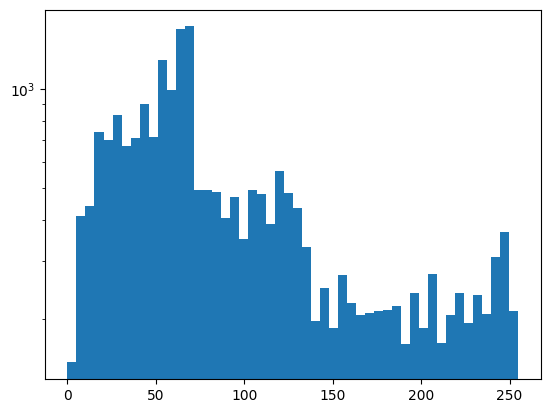

In [8]:
plt.hist(np.array(data)[:,0], bins = 50)
plt.semilogy()
plt.show()

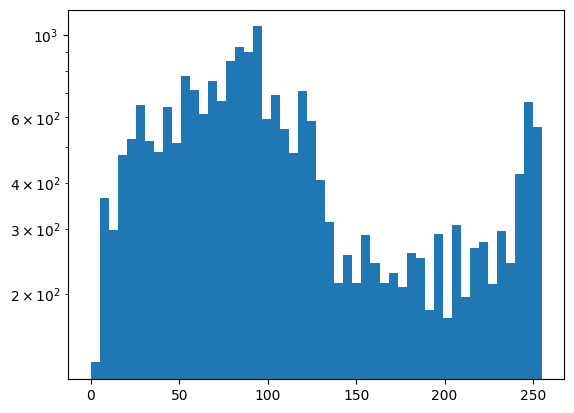

In [9]:
plt.hist(np.array(data)[:,1], bins = 50)
plt.semilogy()
plt.show()

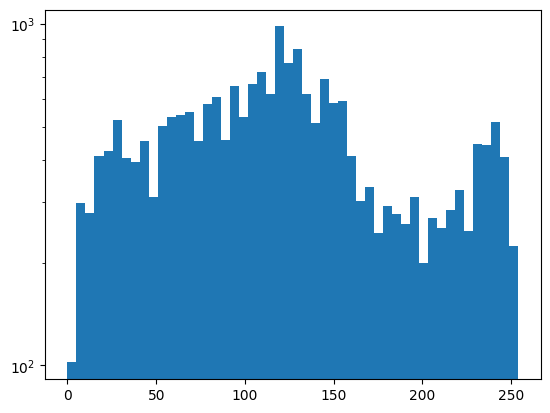

In [10]:
plt.hist(np.array(data)[:,2], bins = 50)
plt.semilogy()
plt.show()

In [11]:
if __name__ == "__main__":
    ref_img = Image.open('../lib/test_target3_slice.png')
    ref_img = ref_img.convert('RGB')
    ref_img.show()
    
    data = list(set(list(Image.Image.getdata(ref_img))))
    R = int(np.mean(np.array(data)[:,0]))
    G = int(np.mean(np.array(data)[:,1]))
    B = int(np.mean(np.array(data)[:,2]))
    
    avg_img = Image.new(mode = 'RGB', size = (369, 378), color = tuple([68,85,125]))
    avg_img.show()
    
    sim = 100 - imgcompare.image_diff_percent(ref_img, avg_img)
    print('Similarity between ref image and averaged image: {}%'.format(sim))

Similarity between ref image and averaged image: 56.024048081543164%


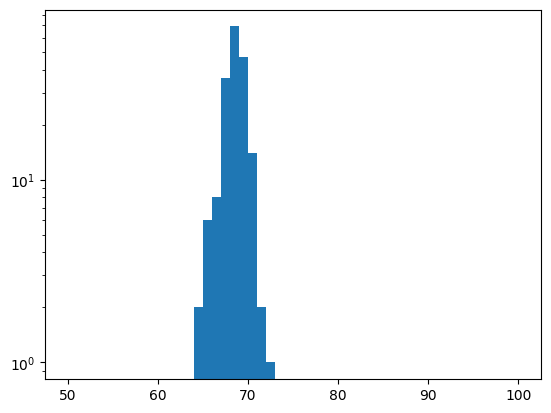

In [12]:
plt.hist(np.array(data)[:,0], bins = 50, range = (50, 100))
plt.semilogy()
plt.show()

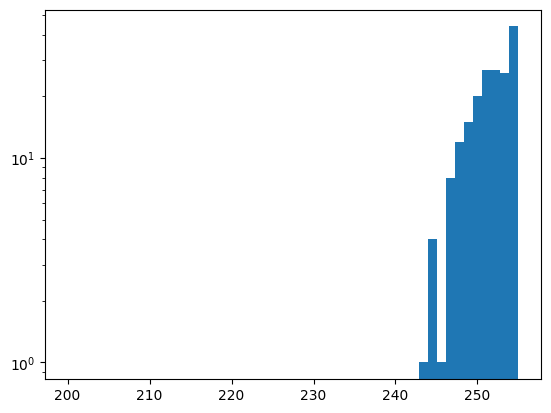

In [13]:
plt.hist(np.array(data)[:,1], bins = 50, range = (200, 255))
plt.semilogy()
plt.show()

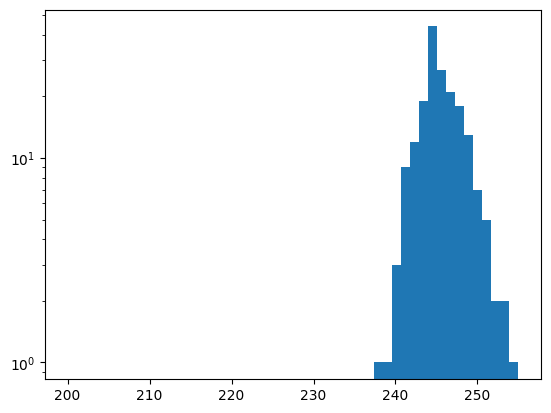

In [14]:
plt.hist(np.array(data)[:,2], bins = 50, range = (200, 255))
plt.semilogy()
plt.show()

In [15]:
# for now, the current evolution process (mean color -> background color) is
# a viable means of approximating the image

# the current evol algorithm can be implemented in app form
# future benchmarks will be added onto the app (developmental)

# in the next benchmark, shapes will be tested while the background will have its own object
# following an algorithm similar to that of benchmark #1, but with more add-ons when shapes are considered...